# VGG
VGG-16 mainly has three parts: convolution, Pooling, and fully connected layers.

Convolution layer- In this layer, filters are applied to extract features from images. The most important parameters are the size of the kernel and stride.

Pooling layer- Its function is to reduce the spatial size to reduce the number of parameters and computation in a network.

Fully Connected- These are fully connected connections to the previous layers as in a simple neural network.

Given figure shows the architecture of the model:
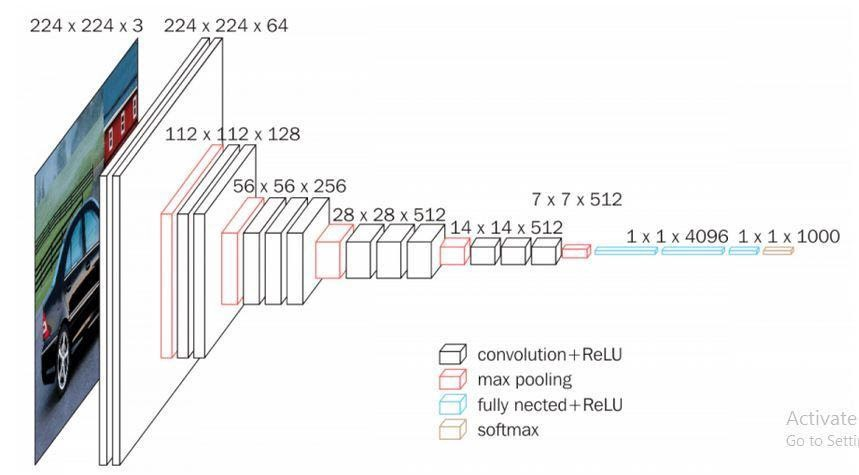

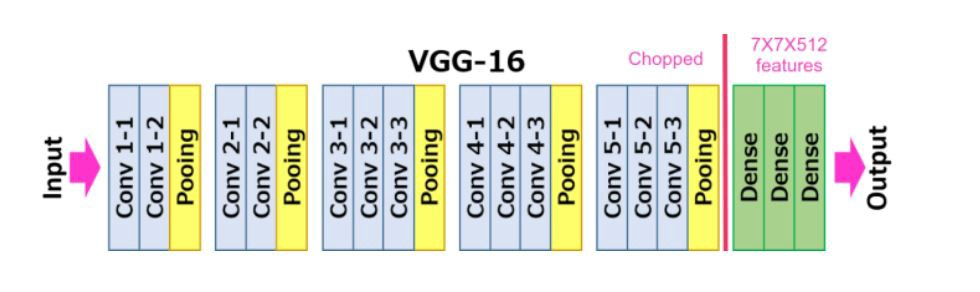

Source

To perform transfer learning import a pre-trained model using PyTorch, remove the last fully connected layer or add an extra fully connected layer in the end as per your requirement(as this model gives 1000 outputs and we can customize it to give a required number of outputs) and run the model.

In [ ]:
### Unzipping Dataset
import zipfile

with zipfile.ZipFile("../vgg/datasets.zip","r") as z:
    z.extractall(".")

In [ ]:
!pip install tqdm

In [ ]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, glob, time, copy, random, zipfile
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

In [ ]:
train_dir = '../vgg/datasets/'

In [ ]:
os.listdir(train_dir)[:5]

['vehicle.744.jpg',
 'architecture.1783.jpg',
 'fastfood.370.jpg',
 'fastfood.1564.jpg',
 'fastfood.947.jpg']

In [ ]:
train_list = glob.glob(os.path.join(train_dir, '*.jpg'))

In [ ]:
# Number of Train Image
len(train_list)

12000

In [ ]:
# Divide Train, Valid Data
train_list, val_list = train_test_split(train_list, test_size=0.1)

In [ ]:
print(len(train_list))
print(len(val_list))

10800
1200


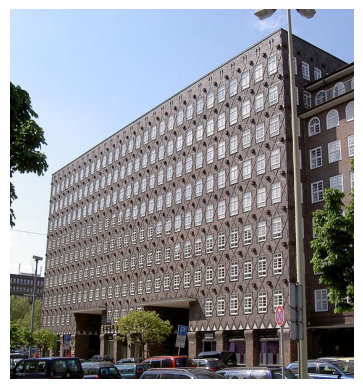

In [ ]:
img = Image.open(train_list[0]).convert('RGB')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
train_list[0].split('/')[-1].split('.')[0]

'architecture'

In [ ]:
# Data Augumentation
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [ ]:
class ClassificationDataset(data.Dataset):
    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')
        
        img_transformed = self.transform(img, self.phase)
        
        # Get Label
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'animal':
            label = 0
        elif label == 'architecture':
            label = 1
        elif label == 'fastfood':
            label = 2
        elif label == 'person':
            label = 3
        elif label == 'plant':
            label = 4
        elif label == 'vehicle':
            label = 5

        return img_transformed, label

In [ ]:
size = 224
mean = (0.5, 0.5, 0.5) #(0.485, 0.456, 0.406)
std = (0.5, 0.5, 0.5) #(0.229, 0.224, 0.225)
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Dataset
train_dataset = ClassificationDataset(train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = ClassificationDataset(val_list, transform=ImageTransform(size, mean, std), phase='val')

In [ ]:
# Operation Check
print('Operation Check')
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])
print(train_dataset.__getitem__(index)[0])

Operation Check
torch.Size([3, 224, 224])
1
tensor([[[-0.8588, -0.8118, -0.7176,  ...,  0.5137,  0.5216,  0.5137],
         [-0.7176, -0.7020, -0.6471,  ...,  0.5137,  0.5137,  0.5137],
         [-0.6392, -0.6471, -0.6314,  ...,  0.5137,  0.5216,  0.5137],
         ...,
         [-0.8118, -0.9059, -0.9608,  ..., -0.2157, -0.8039, -0.8118],
         [-0.8902, -0.9294, -0.9686,  ..., -0.1529, -0.7569, -0.7804],
         [-0.9529, -0.9686, -0.9843,  ..., -0.1765, -0.7647, -0.7569]],

        [[-0.7882, -0.7647, -0.7176,  ...,  0.7412,  0.7490,  0.7412],
         [-0.7255, -0.7098, -0.6627,  ...,  0.7412,  0.7412,  0.7412],
         [-0.6627, -0.6706, -0.6471,  ...,  0.7412,  0.7490,  0.7412],
         ...,
         [-0.9137, -0.9686, -0.9765,  ..., -0.3255, -0.8196, -0.8118],
         [-0.9765, -0.9765, -0.9686,  ..., -0.2706, -0.7882, -0.7882],
         [-0.9765, -0.9608, -0.9451,  ..., -0.2392, -0.7725, -0.7490]],

        [[-0.6392, -0.6549, -0.6392,  ...,  0.9922,  0.9922,  0.9922],
 

In [ ]:
# DataLoader
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

# Operation Check
print('Operation Check')
batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

Operation Check
torch.Size([32, 3, 224, 224])
tensor([2, 3, 5, 4, 0, 1, 3, 0, 3, 2, 2, 0, 1, 4, 0, 1, 2, 4, 5, 0, 3, 4, 4, 2,
        3, 3, 2, 4, 5, 3, 0, 0])


In [ ]:
# VGG16 Model Loading
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
print(net)

/home/zz2941/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zz2941/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Change Last Layer
# Output Features 1000 → 6
net.classifier[6] = nn.Linear(in_features=4096, out_features=6)
print('Done')
print(net)

Done
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [ ]:
# Specify The Layers for updating
params_to_update = []

update_params_name = ['classifier.6.weight', 'classifier.6.bias']

for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

classifier.6.weight
classifier.6.bias


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [ ]:
def train_model(net, dataloader_dict, criterion, optimizer, num_epoch):
    
    since = time.time()
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    net = net.to(device)
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:
            
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    net.load_state_dict(best_model_wts)
    return net

In [ ]:
# Train
num_epoch = 5
net = train_model(net, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/5
--------------------


/tmp/ipykernel_1144/3575029117.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/338 [00:00<?, ?it/s]

train Loss: 0.2298 Acc: 0.9310


  0%|          | 0/38 [00:00<?, ?it/s]

val Loss: 0.1037 Acc: 0.9683
Epoch 2/5
--------------------


  0%|          | 0/338 [00:00<?, ?it/s]

train Loss: 0.1103 Acc: 0.9656


  0%|          | 0/38 [00:00<?, ?it/s]

val Loss: 0.0840 Acc: 0.9725
Epoch 3/5
--------------------


  0%|          | 0/338 [00:00<?, ?it/s]

train Loss: 0.1028 Acc: 0.9681


  0%|          | 0/38 [00:00<?, ?it/s]

val Loss: 0.0801 Acc: 0.9725
Epoch 4/5
--------------------


  0%|          | 0/338 [00:00<?, ?it/s]

train Loss: 0.0906 Acc: 0.9699


  0%|          | 0/38 [00:00<?, ?it/s]

val Loss: 0.0727 Acc: 0.9750
Epoch 5/5
--------------------


  0%|          | 0/338 [00:00<?, ?it/s]

train Loss: 0.0924 Acc: 0.9703


  0%|          | 0/38 [00:00<?, ?it/s]

val Loss: 0.0691 Acc: 0.9750
Training complete in 132m 11s
Best val Acc: 0.975000
